In [1]:
# from bpnetlite import BPNet, ChromBPNet
from tangermeme.io import extract_loci
from tangermeme.predict import predict
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from models import BPExtractor
import data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import gzip
from bpnetlite import BPNet
from scipy.stats import spearmanr, pearsonr

import importlib

importlib.reload(data)

from data import sample_tpm_rows, remove_duplicate_edges, build_enhancer_graph, add_virtual_node

/users/kobbad/anaconda3/envs/diff_model/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = BPNet.from_chrombpnet("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/ATAC/ENCSR291GJU/chrombpnet_model/chrombpnet_wo_bias.h5")

In [3]:
peak_file = "./data.gene_annots_with_strand.tsv"
ref_genome = "/oak/stanford/groups/akundaje/kobbad/CS224W/data/hg38.fa"
signal = "/oak/stanford/groups/akundaje/kobbad/CS224W/data/ENCFF262URW.bigWig"

genes = pd.read_csv(peak_file, sep="\t")

gene_data = "./data/gene_data.tsv"

gene_data_df = pd.read_csv(gene_data, sep="\t")
#loci, signals = extract_loci(peak_file, ref_genome, [signal], verbose=True)

In [4]:
gene_to_strand = dict(zip(genes["gene_id"], genes["strand"]))

In [5]:
gene_data_df["strand"] = gene_data_df["gene_id"].map(gene_to_strand)

gene_data_df.columns

Index(['gene_id', 'seqname', 'start', 'end', 'TPM', 'strand'], dtype='object')

In [6]:
gene_data_df['tss_start'] = gene_data_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)

In [7]:
gene_file = gene_data_df[["seqname", "tss_start"]].rename(columns={"tss_start": "start", "seqname": "chrom"})
gene_file["end"] = gene_file["start"] + 1

expression = gene_data_df["TPM"].values

gene_file.head()

,chrom,start,end
0,chr16,89613308,89613309
1,chr1,86547078,86547079
2,chr10,124942123,124942124
3,chr7,152445477,152445478
4,chr5,172958729,172958730


In [8]:
# filter for regular chromosomes
mask = gene_file.chrom.str.contains("chr[0-9]+")
gene_file = gene_file[mask]
expression = expression[mask]
gene_file.chrom.value_counts()


chrom
chr1     3085
chr2     2479
chr11    1961
chr7     1875
chr3     1820
chr12    1814
chr5     1788
chr17    1787
chr6     1751
chr4     1573
chr16    1559
chr8     1541
chr14    1507
chr19    1506
chr15    1449
chr10    1372
chr9     1367
chr13     899
chr22     854
chr18     824
chr20     767
chr21     571
Name: count, dtype: int64

In [9]:
loci = extract_loci(gene_file, ref_genome, verbose=True)

Loading Loci:   0%|          | 0/34149 [00:00<?, ?it/s]

Loading Loci: 100%|██████████| 34149/34149 [00:07<00:00, 4300.74it/s]


In [10]:
loci.shape, gene_file.shape

(torch.Size([34149, 4, 2114]), (34149, 3))

In [11]:
predictions = predict(model, loci, batch_size=16, verbose=True)

100%|██████████| 2135/2135 [00:18<00:00, 112.46it/s]


PearsonRResult(statistic=0.17543541188796388, pvalue=3.904064684829596e-234)

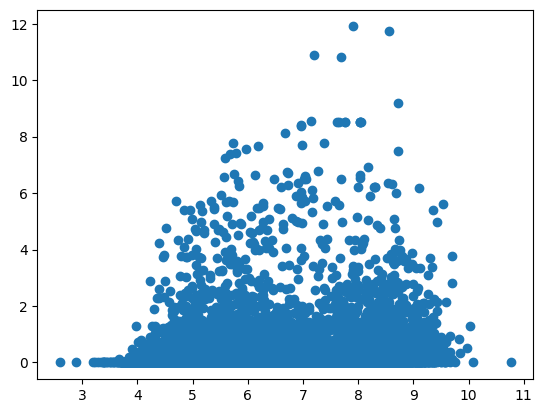

In [12]:
plt.scatter(predictions[1].numpy().squeeze(), np.log1p(expression));
pearsonr(predictions[1].numpy().squeeze(), np.log1p(expression))


<BarContainer object of 2 artists>

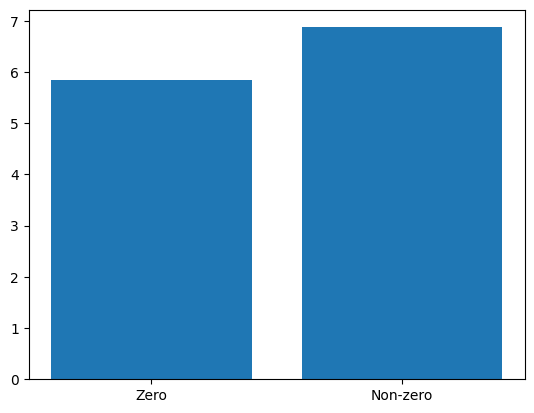

In [19]:
zero_expression_mask = expression < 1

# make a bar plot of average prediction for zero and non-zero expression

plt.bar(["Zero", "Non-zero"], [predictions[1][zero_expression_mask].mean(), predictions[1][~zero_expression_mask].mean()])

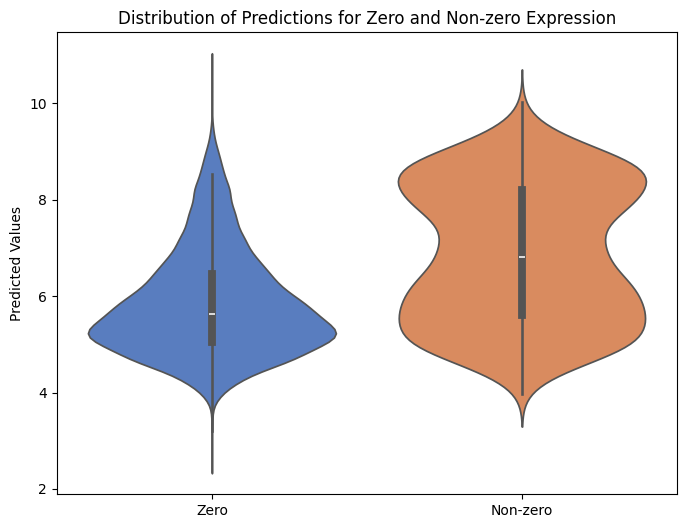

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create data for the violin plot
zero_expression_preds = predictions[1][zero_expression_mask].cpu().numpy().squeeze()
non_zero_expression_preds = predictions[1][~zero_expression_mask].cpu().numpy().squeeze()

# Combine the data into a single array and label them
violin_data = [zero_expression_preds, non_zero_expression_preds]
labels = ["Zero", "Non-zero"]

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=violin_data, palette="muted")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.ylabel("Predicted Values")
plt.title("Distribution of Predictions for Zero and Non-zero Expression")
plt.show()


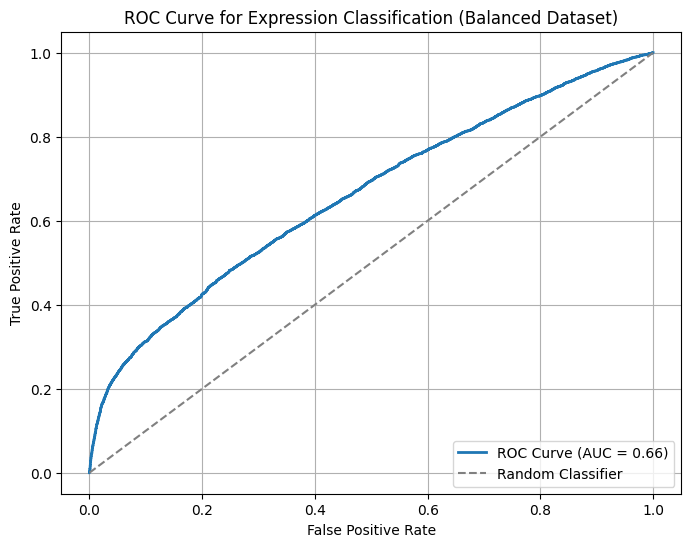

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Convert data to pandas DataFrame for easier manipulation
data = pd.DataFrame({
    "y_true": (expression > 0).astype(int),
    "y_pred": predictions[1].cpu().numpy().squeeze()
})

# Separate data by label
zero_data = data[data["y_true"] == 0]
one_data = data[data["y_true"] == 1]

# Determine the smaller class size for balancing
min_class_size = min(len(zero_data), len(one_data))

# Randomly sample from each class to balance
balanced_zero_data = zero_data.sample(n=min_class_size, random_state=42)
balanced_one_data = one_data.sample(n=min_class_size, random_state=42)

# Combine balanced data
balanced_data = pd.concat([balanced_zero_data, balanced_one_data]).sample(frac=1, random_state=42)  # Shuffle

# Extract balanced labels and predictions
y_true_balanced = balanced_data["y_true"].values
y_pred_balanced = balanced_data["y_pred"].values

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_balanced, y_pred_balanced)
auc = roc_auc_score(y_true_balanced, y_pred_balanced)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Expression Classification (Balanced Dataset)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [23]:
sum(y_true), len(y_true)

(7498, 34149)

In [25]:
# wrapper class to get embeddings 
model_embedding = BPExtractor(model)

In [26]:
embeddings = predict(model_embedding, loci, batch_size=16, verbose=True)

100%|██████████| 2135/2135 [00:18<00:00, 115.28it/s]


In [27]:
embeddings.shape

torch.Size([34149, 512])

In [28]:
embeddings_numpy = embeddings.numpy()

output_dir = "/oak/stanford/groups/akundaje/kobbad/CS224W/data"
embeddings_file_name = "gene_embeddings.npz"

np.savez_compressed(f"{output_dir}/{embeddings_file_name}", embeddings=embeddings_numpy)

In [29]:
gene_file.head()

,chrom,start,end
0,chr16,89613308,89613309
1,chr1,86547078,86547079
2,chr10,124942123,124942124
3,chr7,152445477,152445478
4,chr5,172958729,172958730
